<a href="https://colab.research.google.com/github/oanumnu/MIS-64061_oanumnu./blob/main/weather_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import keras
keras.__version__

'2.4.3'

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os, shutil

In [23]:
data_dir = '/content/drive/MyDrive/climate'
!ls '/content/drive/MyDrive/climate'

jena_climate_2009_2016.csv


In [24]:
import os


fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


convert the 420,551 lines of data into a Numpy array:[link text](https://)

In [25]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Preparing the data 

Preprocess the data 

In [26]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Data Generation

In [27]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [28]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

A basic machine learning approach

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 16s 30ms/step - loss: 1.7288 - val_loss: 0.4200
Epoch 2/20
500/500 [==============================] - 15s 30ms/step - loss: 0.4463 - val_loss: 0.3220
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2988 - val_loss: 0.2977
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2711 - val_loss: 0.3008
Epoch 5/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2578 - val_loss: 0.3243
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2466 - val_loss: 0.3695
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2402 - val_loss: 0.3231
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2356 - val_loss: 0.3096
Epoch 9/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2332 - val_loss: 0.3177
Epoch 10/20
500/500 [==============================] - 15s 31ms/step - loss: 0.228

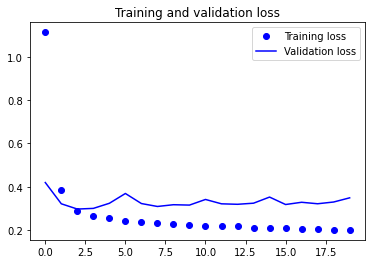

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
Using RNN

In [32]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 91s 179ms/step - loss: 0.3315 - val_loss: 0.2724
Epoch 2/10
500/500 [==============================] - 92s 184ms/step - loss: 0.2865 - val_loss: 0.2704
Epoch 3/10
500/500 [==============================] - 94s 188ms/step - loss: 0.2782 - val_loss: 0.2651
Epoch 4/10
500/500 [==============================] - 89s 178ms/step - loss: 0.2738 - val_loss: 0.2657
Epoch 5/10
500/500 [==============================] - 92s 183ms/step - loss: 0.2677 - val_loss: 0.2818
Epoch 6/10
500/500 [==============================] - 91s 182ms/step - loss: 0.2640 - val_loss: 0.2634
Epoch 7/10
500/500 [==============================] - 91s 182ms/step - loss: 0.2583 - val_loss: 0.2655
Epoch 8/10
500/500 [==============================] - 90s 180ms/step - loss: 0.2513 - val_loss: 0.2718
Epoch 9/10
500/500 [==============================] - 91s 182ms/step - loss: 0.2485 - val_loss: 0.2723
Epoch 10/10
500/500 [==============================] - 92s 185ms/step - l

Let look at our results:

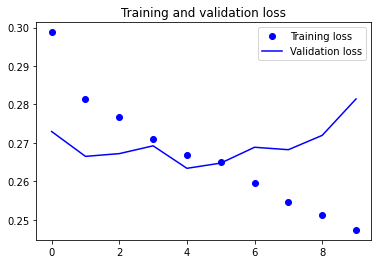

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Using recurrent dropout to fight overfitting

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 144s 284ms/step - loss: 0.3309 - val_loss: 0.2764
Epoch 2/10
500/500 [==============================] - 138s 277ms/step - loss: 0.3056 - val_loss: 0.2699
Epoch 3/10
500/500 [==============================] - 140s 281ms/step - loss: 0.2999 - val_loss: 0.2708
Epoch 4/10
500/500 [==============================] - 141s 283ms/step - loss: 0.2980 - val_loss: 0.2658
Epoch 5/10
500/500 [==============================] - 140s 280ms/step - loss: 0.2907 - val_loss: 0.2686
Epoch 6/10
500/500 [==============================] - 138s 277ms/step - loss: 0.2870 - val_loss: 0.2687
Epoch 7/10
500/500 [==============================] - 139s 277ms/step - loss: 0.2845 - val_loss: 0.2695
Epoch 8/10
500/500 [==============================] - 138s 276ms/step - loss: 0.2810 - val_loss: 0.2658
Epoch 9/10
500/500 [==============================] - 137s 275ms/step - loss: 0.2791 - val_loss: 0.2875
Epoch 10/10
500/500 [==============================] - 138s 276m

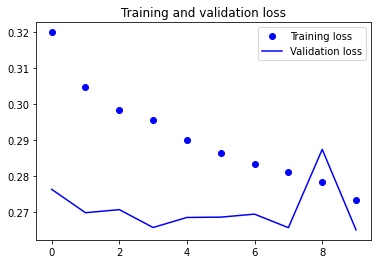

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

using Stacking recurrent layers

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 405s 801ms/step - loss: 0.3469 - val_loss: 0.2766
Epoch 2/10
500/500 [==============================] - 406s 812ms/step - loss: 0.3017 - val_loss: 0.2748
Epoch 3/10
500/500 [==============================] - 415s 830ms/step - loss: 0.2980 - val_loss: 0.2821
Epoch 4/10
500/500 [==============================] - 417s 833ms/step - loss: 0.2909 - val_loss: 0.2836
Epoch 5/10
500/500 [==============================] - 411s 823ms/step - loss: 0.2843 - val_loss: 0.2724
Epoch 6/10
500/500 [==============================] - 413s 826ms/step - loss: 0.2759 - val_loss: 0.2819
Epoch 7/10
500/500 [==============================] - 414s 829ms/step - loss: 0.2689 - val_loss: 0.2806
Epoch 8/10
500/500 [==============================] - 414s 829ms/step - loss: 0.2656 - val_loss: 0.2823
Epoch 9/10
500/500 [==============================] - 414s 828ms/step - loss: 0.2608 - val_loss: 0.2934
Epoch 10/10
500/500 [==============================] - 413s 826m

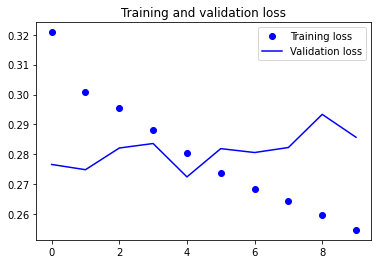

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Using bidirectional RNNs

In [33]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [36]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 99s 194ms/step - loss: 0.5358 - val_loss: 0.4818
Epoch 2/20
500/500 [==============================] - 93s 185ms/step - loss: 0.4555 - val_loss: 0.4668
Epoch 3/20
500/500 [==============================] - 95s 189ms/step - loss: 0.4053 - val_loss: 0.4325
Epoch 4/20
500/500 [==============================] - 91s 182ms/step - loss: 0.3615 - val_loss: 0.4039
Epoch 5/20
500/500 [==============================] - 92s 184ms/step - loss: 0.3334 - val_loss: 0.3853
Epoch 6/20
500/500 [==============================] - 94s 188ms/step - loss: 0.3107 - val_loss: 0.3796
Epoch 7/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2948 - val_loss: 0.3652
Epoch 8/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2806 - val_loss: 0.3650
Epoch 9/20
500/500 [==============================] - 93s 187ms/step - loss: 0.2685 - val_loss: 0.3557
Epoch 10/20
500/500 [==============================] - 93s 186ms/step - l

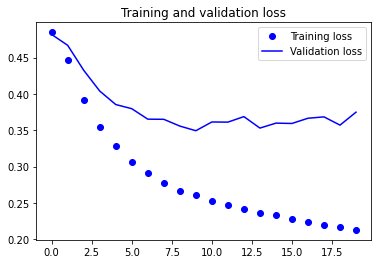

In [40]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
from keras import backend as K
K.clear_session()

In [45]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 160s 312ms/step - loss: 0.3124 - val_loss: 0.2731
Epoch 2/10
500/500 [==============================] - 155s 310ms/step - loss: 0.2761 - val_loss: 0.2780
Epoch 3/10
500/500 [==============================] - 155s 310ms/step - loss: 0.2668 - val_loss: 0.2727
Epoch 4/10
500/500 [==============================] - 156s 311ms/step - loss: 0.2622 - val_loss: 0.2679
Epoch 5/10
500/500 [==============================] - 156s 312ms/step - loss: 0.2577 - val_loss: 0.2686
Epoch 6/10
500/500 [==============================] - 159s 318ms/step - loss: 0.2509 - val_loss: 0.2678
Epoch 7/10
500/500 [==============================] - 158s 316ms/step - loss: 0.2456 - val_loss: 0.2730
Epoch 8/10
500/500 [==============================] - 157s 314ms/step - loss: 0.2380 - val_loss: 0.2801
Epoch 9/10
500/500 [==============================] - 156s 313ms/step - loss: 0.2320 - val_loss: 0.2751
Epoch 10/10
500/500 [==============================] - 155s 310m

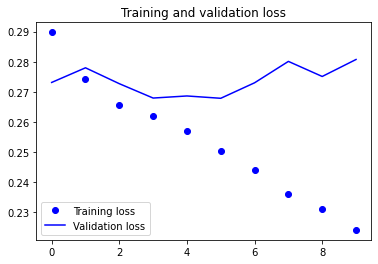

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [50]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
test_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [60]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=test_gen_reverse,
                              validation_steps=test_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 101s 199ms/step - loss: 0.4981 - val_loss: 0.4909
Epoch 2/10
500/500 [==============================] - 97s 193ms/step - loss: 0.4476 - val_loss: 0.4852
Epoch 3/10
500/500 [==============================] - 97s 194ms/step - loss: 0.3999 - val_loss: 0.4363
Epoch 4/10
500/500 [==============================] - 98s 195ms/step - loss: 0.3523 - val_loss: 0.4509
Epoch 5/10
500/500 [==============================] - 97s 194ms/step - loss: 0.3309 - val_loss: 0.4215
Epoch 6/10
500/500 [==============================] - 98s 197ms/step - loss: 0.3131 - val_loss: 0.4268
Epoch 7/10
500/500 [==============================] - 99s 198ms/step - loss: 0.2958 - val_loss: 0.4050
Epoch 8/10
500/500 [==============================] - 98s 196ms/step - loss: 0.2803 - val_loss: 0.3979
Epoch 9/10
500/500 [==============================] - 96s 193ms/step - loss: 0.2680 - val_loss: 0.3839
Epoch 10/10
500/500 [==============================] - 96s 191ms/step - 

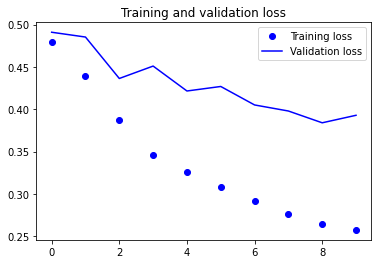

In [61]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



Using RNN - We got a validation MAE of 0.2651 @ 3epochs before the model starts to overfit


Using recurrent drop out – we got a validation MAE of 0.2658 @4epochs before the model starts to overfit



Using stacking recurrent layers – we got a validation MAE of 0.2724@ 5epochs before the model starts to  overfit


Using Bidirectional RNN’s (reverse order)– we got a validation MAE of 0.3493 @ 10epochs before the model starts to overfit


Adjusting the bidirectional RNN’s to chronological order-  we got a validation MAE of 0.2780 @ 2epochs before the model starts to overfit


Applying Bidirectional RNN (reverse order) to our test data – we got a validation MAE of 0.4363 @ 3epochs before the model starts to overfit
